<a href="https://colab.research.google.com/github/saratkv/HandsOn_Unsupervised_Learning_with_Python/blob/master/chapter02/vq_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

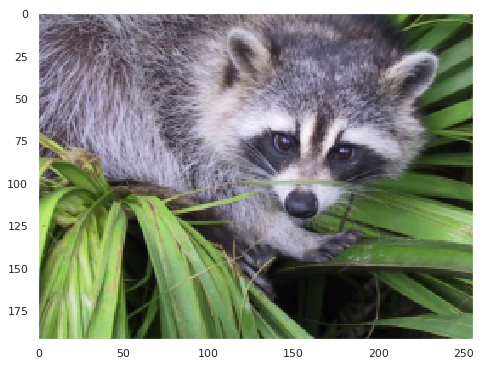

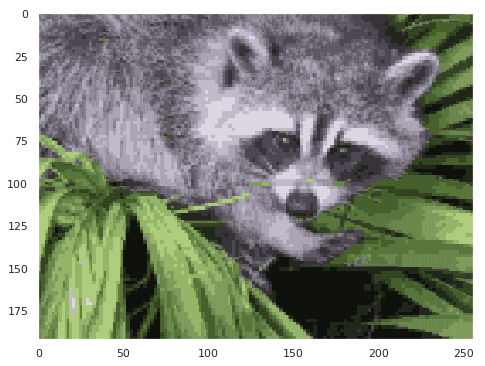

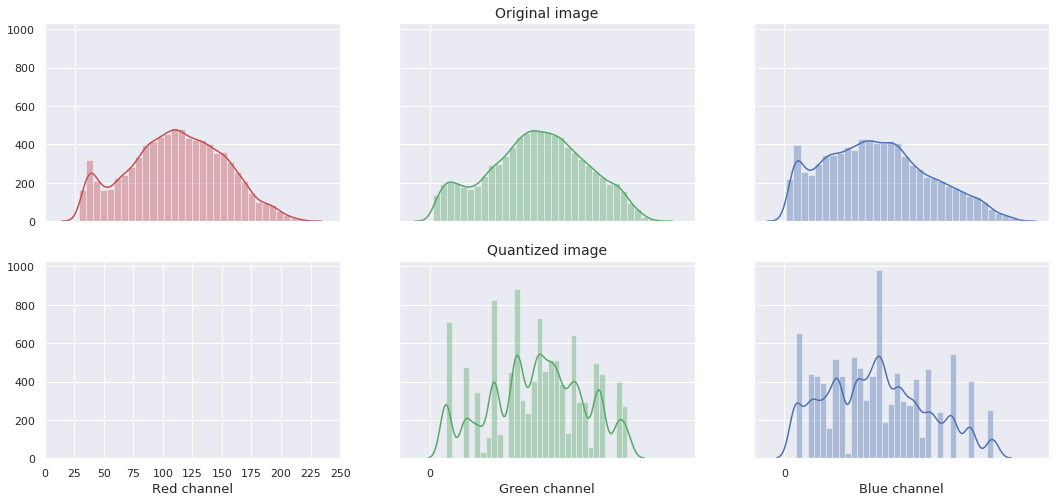

Original entropy: 7.715 bits - Quantized entropy: 5.871 bits


In [8]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.misc import face
from skimage.transform import resize

from sklearn.cluster import KMeans


# For reproducibility
np.random.seed(1000)


square_fragment_size = 2
n_qvectors = 24


if __name__ == '__main__':
    # Load and resize the image
    picture = resize(face(gray=False), output_shape=(192, 256), mode='reflect')

    # Show the original image
    sns.set()

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(picture)
    ax.grid(False)

    plt.show()

    # Collect all 2x2 fragments
    n_fragments = int(picture.shape[0] * picture.shape[1] / (square_fragment_size ** 2))

    fragments = np.zeros(shape=(n_fragments, square_fragment_size ** 2 * picture.shape[2]))
    idx = 0

    for i in range(0, picture.shape[0], square_fragment_size):
        for j in range(0, picture.shape[1], square_fragment_size):
            fragments[idx] = picture[i:i + square_fragment_size,
                             j:j + square_fragment_size, :].flatten()
            idx += 1

    # Perform the quantization
    km = KMeans(n_clusters=n_qvectors, random_state=1000)
    km.fit(fragments)

    qvs = km.predict(fragments)

    # Build the quantized image
    qv_picture = np.zeros(shape=(192, 256, 3))
    idx = 0

    for i in range(0, 192, square_fragment_size):
        for j in range(0, 256, square_fragment_size):
            qv_picture[i:i + square_fragment_size,
                       j:j + square_fragment_size, :] = \
                km.cluster_centers_[qvs[idx]].\
                    reshape((square_fragment_size, square_fragment_size, 3))
            idx += 1

    # Show the final image
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(qv_picture)
    ax.grid(False)

    plt.show()

    # Show the histograms
    fig, ax = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)

    sns.distplot(picture[:, :, 0].flatten() / 255.0, kde=True, bins=32, ax=ax[0, 0], color='r')
    sns.distplot(picture[:, :, 1].flatten() / 255.0, kde=True, bins=32, ax=ax[0, 1], color='g')
    sns.distplot(picture[:, :, 2].flatten() / 255.0, kde=True, bins=32, ax=ax[0, 2], color='b')

    sns.distplot(qv_picture[:, :, 0].flatten() / 255.0, kde=True, bins=32, ax=ax[1, 0], color='r')
    sns.distplot(qv_picture[:, :, 1].flatten() / 255.0, kde=True, bins=32, ax=ax[1, 1], color='g')
    sns.distplot(qv_picture[:, :, 2].flatten() / 255.0, kde=True, bins=32, ax=ax[1, 2], color='b')

    ax[0, 1].set_title('Original image', fontsize=14)
    ax[1, 1].set_title('Quantized image', fontsize=14)

    ax[1, 0].set_xlabel('Red channel', fontsize=13)
    ax[1, 1].set_xlabel('Green channel', fontsize=13)
    ax[1, 2].set_xlabel('Blue channel', fontsize=13)

    ax[1, 0].set_xticks(np.arange(0, 256, 25))

    plt.show()

    # Compute the entropy of the red channels
    hist_original, _ = np.histogram(picture[:, :, 0].flatten() * 255.0, bins=256)
    hist_q, _ = np.histogram(qv_picture[:, :, 0].flatten() * 255.0, bins=256)

    p_original = hist_original / np.sum(hist_original)
    H_original = -np.sum(p_original * np.log2(p_original + 1e-8))

    p_q = hist_q / np.sum(hist_q)
    H_q = -np.sum(p_q * np.log2(p_q + 1e-8))

    print('Original entropy: {0:.3f} bits - Quantized entropy: {1:.3f} bits'.format(H_original, H_q))
    